# Classification d'images en Deep Learning - Classificateur binaire

Ceci est notre première tentative de classification de terrains en Deep Learning. Afin de pouvoir reconnaître nos terrains uniquement à partir d'images de ceux-ci, il est nécessaire de construire des [OCC ("One-Class Classifier")](https://en.wikipedia.org/wiki/One-class_classification).

### Entraîner un classificateur d'images

1. Charger et normaliser nos ensembles de données d'entraînement et de test en utilisant *torchvision*.
2. Définir un réseau neural convolutif (CNN)
3. Définir une fonction de perte
4. Former le réseau sur les données relatives à l'entraînement
5. Vérifier la validité du réseau sur les données de test

**1. Charger et normaliser nos ensembles de données**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

Les ensembles de données *torchvision* sont des images PILImage de portée [0, 1].
Nous les transformons en Tenseurs de portée normalisée [-1, 1].

In [2]:
trainset = torchvision.datasets.ImageFolder(root="data/classifier/training",
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

validationset = torchvision.datasets.ImageFolder(root="data/classifier/validation",
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

validationloader = torch.utils.data.DataLoader(validationset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('voiture', 'terrain')

Voici quelques images de l'ensemble d'entraînement avec leur classe associée.



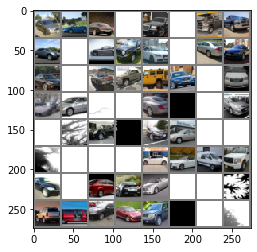

voiture voiture voiture terrain


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**2. Définir un réseau neural convolutif (CNN)**

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

**3. Définir une fonction de perte et un optimisateur**

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**4. Entraîner le réseau**

In [6]:
print("Starting Training Loop...")
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, val_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        optimizer.zero_grad()
        logps = net.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            val_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in validationloader:
                    logps = net.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    val_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            val_losses.append(val_loss/len(validationloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {val_loss/len(validationloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validationloader):.3f}")
            running_loss = 0
            net.train()

print('Finished Training')

Starting Training Loop...
Epoch 1/10.. Train loss: 2.265.. Test loss: 2.244.. Test accuracy: 0.451
Epoch 1/10.. Train loss: 2.223.. Test loss: 2.191.. Test accuracy: 0.935
Epoch 1/10.. Train loss: 2.168.. Test loss: 2.131.. Test accuracy: 0.925
Epoch 1/10.. Train loss: 2.107.. Test loss: 2.070.. Test accuracy: 0.931
Epoch 1/10.. Train loss: 2.046.. Test loss: 2.004.. Test accuracy: 0.929
Epoch 1/10.. Train loss: 1.975.. Test loss: 1.925.. Test accuracy: 0.907
Epoch 1/10.. Train loss: 1.888.. Test loss: 1.818.. Test accuracy: 0.799
Epoch 2/10.. Train loss: 1.761.. Test loss: 1.627.. Test accuracy: 0.574
Epoch 2/10.. Train loss: 1.522.. Test loss: 1.243.. Test accuracy: 0.512
Epoch 2/10.. Train loss: 1.102.. Test loss: 0.840.. Test accuracy: 0.512
Epoch 2/10.. Train loss: 0.858.. Test loss: 0.639.. Test accuracy: 0.512
Epoch 2/10.. Train loss: 0.643.. Test loss: 0.522.. Test accuracy: 0.895
Epoch 2/10.. Train loss: 0.553.. Test loss: 0.455.. Test accuracy: 0.715
Epoch 2/10.. Train loss: 

Sauvegarde de notre réseau, on peut ensuite le recharger via:
```py
net = Net()
net.load_state_dict(torch.load('models/classifier.pt'))
```

In [7]:
torch.save(net.state_dict(), 'models/classifier.pt')

On affiche le graphique des pertes:

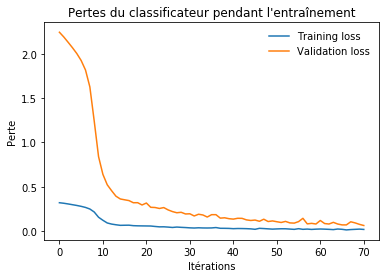

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title("Pertes du classificateur pendant l'entraînement")
plt.xlabel("Itérations")
plt.ylabel("Perte")
plt.legend(frameon=False)
plt.savefig('data/classifier/latest.png')
plt.show()

**5. Vérifier la validité du réseau sur les données de validation**

Nous avons formé le réseau à l'aide de l'ensemble des données de formation mais nous devons vérifier si le réseau a appris quelque chose. Nous pouvons le faire en lui donnant une image et en vérifiant que la classe qu'il a associé à cette image est correcte. 

Voici quelques images de l'ensemble de validation avec leur classe associée.

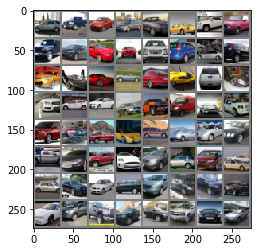

Classe:  voiture voiture voiture voiture


In [9]:
dataiter = iter(validationloader)
dataiter.next()
dataiter.next()
dataiter.next()
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Classe: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

On peut maintenant voir quelles sont les prédictions de notre classificateur pour les images ci-dessus:


In [10]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Prédictions: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Prédictions:  voiture voiture voiture voiture


Les résultats semblent bons.
Voyons maintenant les performances de notre réseau sur tout l'ensemble de données de validation:

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 98 %


Précision par classe:


In [12]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of voiture : 100 %
Accuracy of terrain : 100 %


Il est maintenant temps de tester notre classificateur avec des données qui lui sont inconnues:

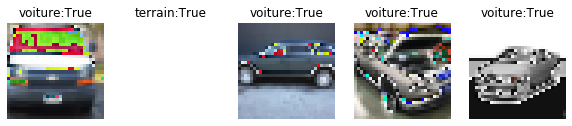

In [18]:
test_transforms = transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = torch.autograd.Variable(image_tensor)
    output = net(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    
    data = torchvision.datasets.ImageFolder('data/classifier/test', transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()